In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.inspection import partial_dependence

# Set font before plotting
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [14]:
# Read the CSV
df = pd.read_csv('C:/Users/User/Downloads/Kyushu Datasheets/data_with_press_and_weather.csv', low_memory=False)

# Drop rows with excessive missing values
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    threshold = df.shape[1] // 2
    df = df.dropna(thresh=threshold + 1)
    print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")
else:
    print("No missing values found.")

Rows with more than half NaN dropped. Remaining rows: 2811


In [15]:
# Clean and filter '강번'
df['강번'] = pd.to_numeric(df['강번'], errors='coerce')
df = df.dropna(subset=['강번'])
df = df[df['강번'].between(9000, 500000000)]
df = df[df['수율'].between(60, 100)]

df.to_csv('For_my_use_1.csv', index=False)

# Make sure the date column is in datetime format
df['날짜'] = pd.to_datetime(df['날짜'], errors='coerce')

chin_variables = [col for col in df.columns if '친' in col and '친단' not in col]
df['chin_total'] = df[chin_variables].sum(axis=1)

In [16]:
average_additional_power_total = df['유효전력량_주장'].mean()

print(f"Average 유효전력량_주장: {average_additional_power_total:.2f}")

Average 유효전력량_주장: 5955.87


In [17]:
def plot_column_by_date(df, column, start_date, end_date, exclude=None, marker_between=None, mean_line=None):
    """
    Selects data between start_date and end_date (from '날짜'), but plots using index as x-axis.
    
    Parameters:
        column (str): Name of the column to plot (e.g., '사용전력량')
        start_date (str or datetime): Start date for filtering
        end_date (str or datetime): End date for filtering
        exclude (list): List of row positions to exclude from the plot
        marker_between (tuple): (i1, i2) row positions to draw vertical marker between
        mean_line (float): y-value to draw horizontal mean line
    """
    exclude = exclude or []
    
    # Ensure 날짜 is datetime
    df['날짜'] = pd.to_datetime(df['날짜'], errors='coerce')
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Get filtered DataFrame rows within date range
    date_mask = (df['날짜'] >= start_date) & (df['날짜'] <= end_date)
    selected_indices = df[date_mask].index.tolist()

    if not selected_indices:
        print("No matching 날짜 found in the specified range.")
        return

    # Prepare plot data: x = index, y = value
    x_indices = []
    y_values = []
    for i in selected_indices:
        if i in exclude:
            continue
        x_indices.append(i)
        y_values.append(df.loc[i, column])

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(x_indices, y_values, marker='o', linestyle='-', label=column)

    # Vertical line between two dates
    if marker_between:
        try:
            # Parse input dates
            date1 = pd.to_datetime(marker_between[0])
            date2 = pd.to_datetime(marker_between[1])

            # Get rows exactly on those dates (not closest)
            idxs_date1 = df[date_mask & (df['날짜'] == date1)].index
            idxs_date2 = df[date_mask & (df['날짜'] == date2)].index

            if len(idxs_date1) == 0 or len(idxs_date2) == 0:
                print(f"Date(s) not found in range: {date1.date()}, {date2.date()}")
            else:
                last_idx_date1 = idxs_date1[-1]
                first_idx_date2 = idxs_date2[0]
                midpoint = (last_idx_date1 + first_idx_date2) / 2
                plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=2,
                            label=f'Marker between {date1.date()} and {date2.date()}')
        except Exception as e:
            print(f"Error processing marker_between: {e}")


    # Optional horizontal mean line
    if mean_line is not None:
        plt.axhline(y=mean_line, color='gray', linestyle='--', linewidth=2, label=f'Mean = {mean_line:.2f}')

    # Final plot config
    plt.title(f"{column} from {start_date.date()} to {end_date.date()}")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [18]:
def compute_windowed_means_readable(df, column, target_date):
    """
    Computes and returns readable mean values of a column around a target date.

    Windows:
        - Day before (D-1)
        - 3 days before (D-3 to D-1)
        - Target day (D)
        - Target day and 2 days after (D to D+2)

    If column is 'chin_total', only values over 28,000 are used.

    Parameters:
        df (pd.DataFrame): Must include '날짜' and the target column
        column (str): Column to calculate means for
        target_date (str or datetime): The date around which to calculate means

    Returns:
        str: Formatted summary of means for each window
    """
    import pandas as pd

    # Ensure datetime
    df['날짜'] = pd.to_datetime(df['날짜'], errors='coerce')
    target_date = pd.to_datetime(target_date)

    windows = {
        'Day Before (D-1)': (target_date - pd.Timedelta(days=1), target_date - pd.Timedelta(days=1)),
        '3 Days Before (D-3 to D-1)': (target_date - pd.Timedelta(days=3), target_date - pd.Timedelta(days=1)),
        'Target Day (D)': (target_date, target_date),
        'Target + 2 Days (D to D+2)': (target_date, target_date + pd.Timedelta(days=2))
    }

    results = []
    for label, (start, end) in windows.items():
        mask = (df['날짜'] >= start) & (df['날짜'] <= end)
        window_df = df.loc[mask]

        # Apply filter for 'chin_total'
        if column == 'chin_total':
            window_df = window_df[window_df[column] > 28000]

        mean_val = window_df[column].mean()
        formatted_mean = f"{mean_val:,.2f}" if pd.notna(mean_val) else "N/A"
        results.append(f"{label}: {formatted_mean}")

    return "\n".join(results)


In [30]:
date_first= '2024-01-01'
date_last = '2024-12-31'
date_of = '2024-05-22'
date_before = '2024-05-21'

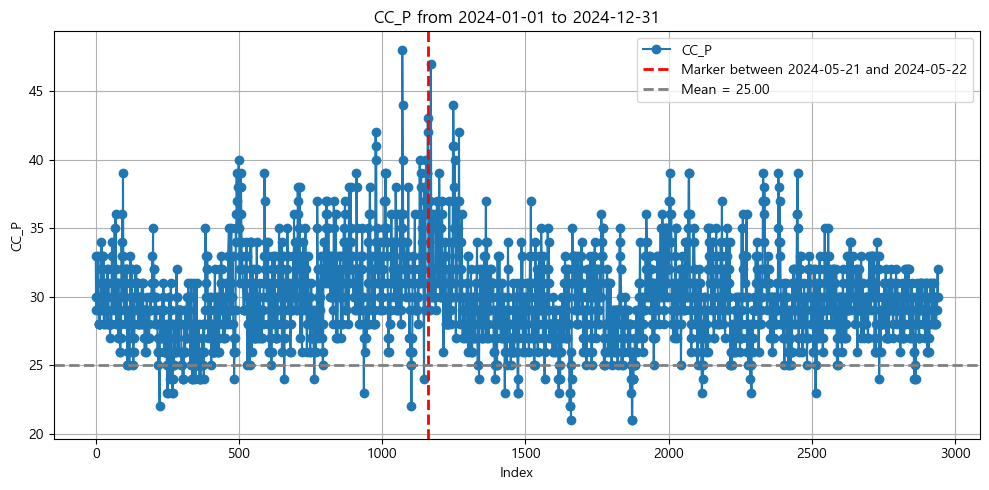

Day Before (D-1): 39.29
3 Days Before (D-3 to D-1): 35.28
Target Day (D): 31.50
Target + 2 Days (D to D+2): 32.30


In [31]:
plot_column_by_date(df, 'CC_P', date_first, date_last, exclude= [], marker_between= (date_before, date_of), mean_line=25)
print(compute_windowed_means_readable(df, 'CC_P', date_of))

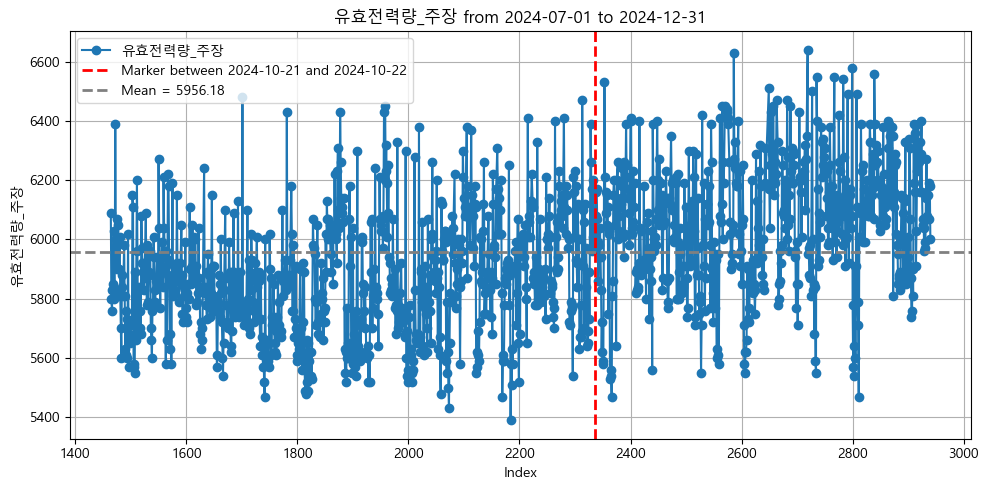

Day Before (D-1): 6,123.75
3 Days Before (D-3 to D-1): 5,965.53
Target Day (D): 6,044.29
Target + 2 Days (D to D+2): 5,902.14


In [21]:
date_first= '2024-07-01'
date_last = '2024-12-31'
date_of = '2024-10-22'
date_before = '2024-10-21'

plot_column_by_date(df, '유효전력량_주장', date_first, date_last, exclude= [], marker_between= (date_before, date_of), mean_line=5956.18)
print(compute_windowed_means_readable(df, '유효전력량_주장', date_of))

In [ ]:
CC_p = df['CC_p']

# Final plot config
plt.title(f"{column} from {start_date.date()} to {end_date.date()}")
plt.xlabel(MD_P)
plt.ylabel(CC_p)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

KeyError: 'CC_p'